In [1]:
%load_ext autoreload
%autoreload 2

# Can U-Net predict only the evidence?

What exactly _is_ the evidence in the Skyline12 dataset anyways?

It's actually _scribbles_ that _roughly_ indicate the position of building on the image. There is an individual scribble (points that form a path of a brush stroke) for each building. In our case, to make them usable we create white brush stroke (of a set stroke size) on a black canvas of the same dimensions as each corresponding image. So the evidence is actually an image with black and white pixels.

In [2]:
from datasets.skyline12 import Skyline12

skyline12 = Skyline12('datasets/skyline12/data/')

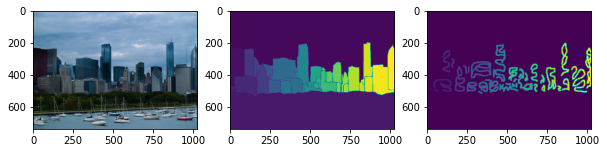

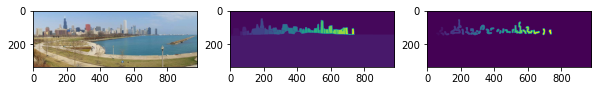

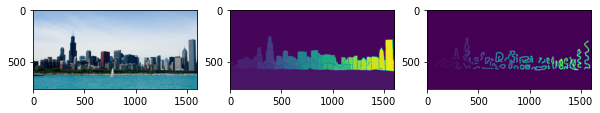

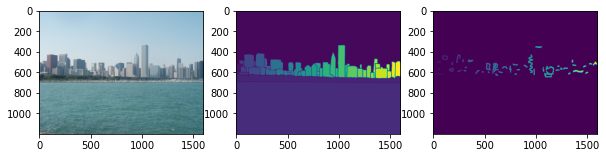

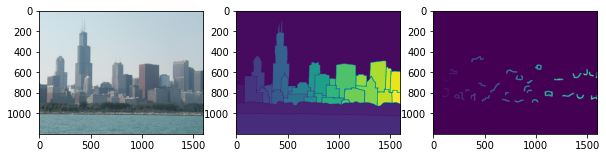

In [3]:
from itertools import islice

for x, y, z in islice(skyline12, 5):
    Skyline12.show_sample(x, [y, z])

As we can see from the small preview of the dataset (ignoring the different colormapping), the scribbles are really sparse. This is expected, as the buildings, at least in the original untampered dataset, take up only a portion of the image. Even so, the density of the drawings vary significantly.

In [4]:
# measuring the class balance
import numpy as np


def get_class_ratio(img):
    img = np.ravel(img)
    pos = img[img > 0]
    neg = img[img == 0]
    return 100 * len(pos) / (len(pos) + len(neg))


class_ratios = np.array([get_class_ratio(z) for _, _, z in skyline12])

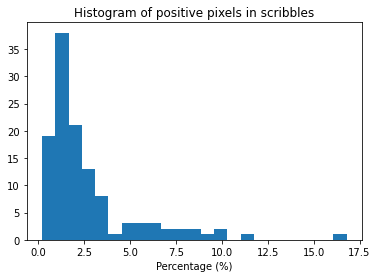

In [5]:
import matplotlib.pyplot as plt

plt.hist(class_ratios, 'auto')
plt.title('Histogram of positive pixels in scribbles')
plt.xlabel('Percentage (%)');

We see that in most of the images in the original Skyline12 dataset, scribbles are less than 2% of the total pixels. That makes it a problem of _class imbalance_ that we need to deal with if we want the model to train fast enough and not spend a number of epochs just to learn to ignore the 0-value pixels. Even worse, it _could_ get trapped in a local minimum, depeding of the loss function and activation that we choose.

That said, U-Net is a _Fully Convolutional Network_ and, as Long _et al_ found in their [Fully Convolutional Networks for Semantic Segmentation](https://www.cv-foundation.org/openaccess/content_cvpr_2015/html/Long_Fully_Convolutional_Networks_2015_CVPR_paper.html) paper, class balancing should be unnecessary. Fully convolutional training regulates the imbalance by weighting or sampling the loss.

## Training with default settings

In [7]:
import tensorflow as tf
import numpy as np
from models.unet import create_unet

tf.random.set_seed(123)
np.random.seed(123)

ds = skyline12.as_tf_dataset(folds=1).map(lambda x, y, z: (x, z))

unet = create_unet(num_classes=1, output_activation='sigmoid')
unet.compile(loss='binary_crossentropy', optimizer='adam')
history = unet.fit(ds.batch(4).cache(), epochs=20)

Epoch 1/20
      2/Unknown - 0s 187ms/step - loss: 3.1688WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1199s vs `on_train_batch_end` time: 0.2493s). Check your callbacks.
30/30 [==============================] - 48s 2s/step - loss: 0.4048
Epoch 2/20
30/30 [==============================] - 11s 364ms/step - loss: 0.2010
Epoch 3/20
30/30 [==============================] - 11s 363ms/step - loss: 0.1973
Epoch 4/20
30/30 [==============================] - 11s 363ms/step - loss: 0.1948
Epoch 5/20
30/30 [==============================] - 11s 364ms/step - loss: 0.1911
Epoch 6/20
30/30 [==============================] - 11s 363ms/step - loss: 0.1907
Epoch 7/20
30/30 [==============================] - 11s 363ms/step - loss: 0.1887
Epoch 8/20
30/30 [==============================] - 11s 363ms/step - loss: 0.1884
Epoch 9/20
30/30 [==============================] - 11s 364ms/step - loss: 0.1872
Epoch 10/20
30/30 [=========================

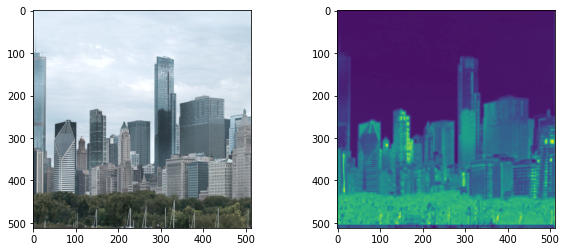

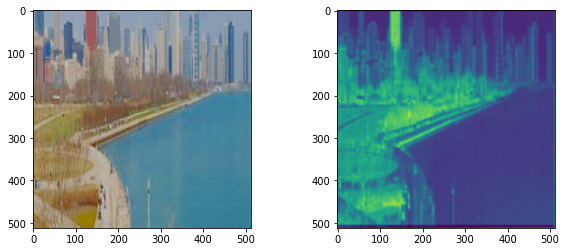

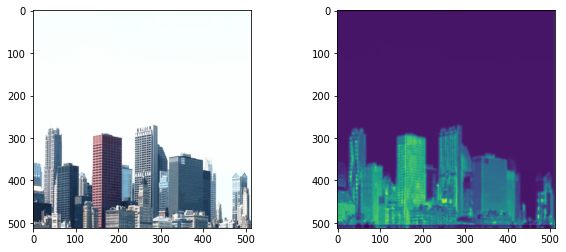

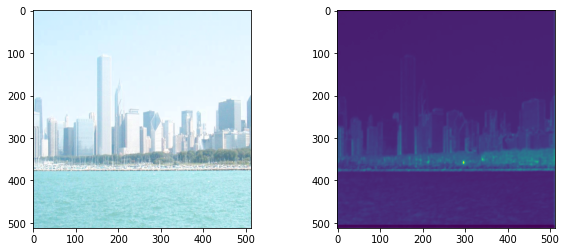

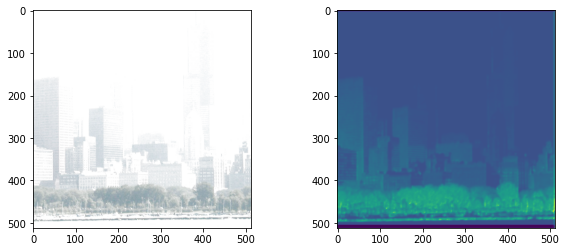

In [8]:
for x, _ in islice(ds.batch(1), 5):
    preds = unet(x, training=False)
    Skyline12.show_sample(x[0], [preds[0]], from_tensors=True)

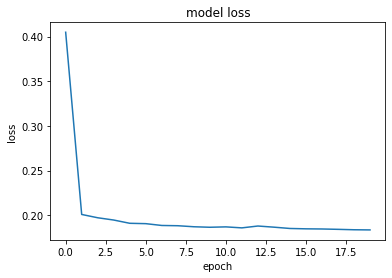

In [9]:
import matplotlib.pyplot as plt


def plot_history(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()


plot_history(history)

With the model seemignly converging, the predictions are nothing close to the scribbles.

Let's try on a bigger version of the (augmented) dataset

In [ ]:
!mkdir -p /tmp/ds_cache/
tf.random.set_seed(123)
np.random.seed(123)
ds = skyline12.as_tf_dataset(folds=20, cache_dir='/tmp/ds_cache/').map(
    lambda x, y, z: (x, z))

unet = create_unet(num_classes=1, output_activation='sigmoid')
unet.compile(loss='binary_crossentropy', optimizer='adam')
history = unet.fit(
    ds.batch(4),
    epochs=20
)

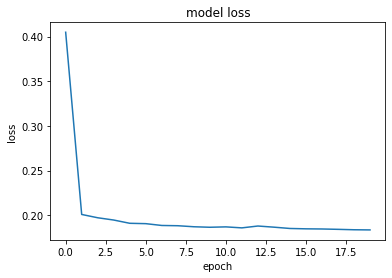

In [11]:
plot_history(history)

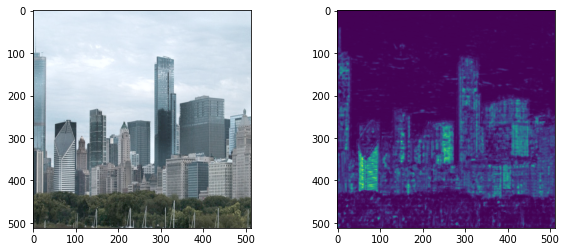

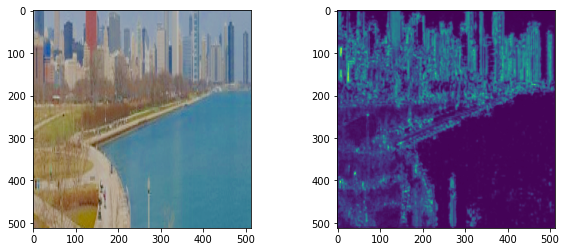

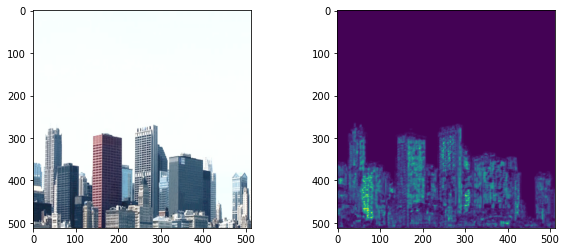

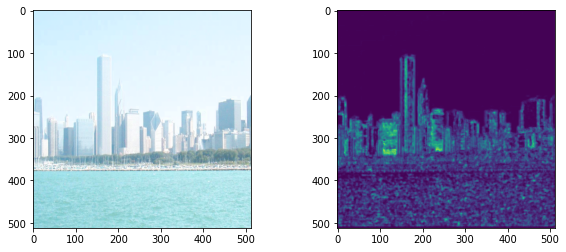

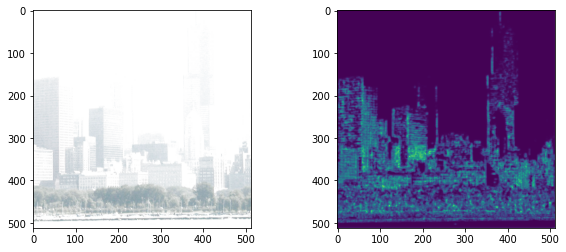

In [17]:
for x, _ in islice(ds.batch(1), 5):
    preds = unet(x, training=False)
    Skyline12.show_sample(x[0], [preds[0]], from_tensors=True)

The output still if nothing like scribbles although there is a faint improvement of having a more similar texture than before. Still we have large portions of an image mispredicted, like in the second sample of the batch above, where the most of the ground is also "scribblified".